In [94]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import BCELoss
from torch.optim import SGD, Adam
from keras_preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import tqdm
import time

In [95]:
class TextCodeDataset(Dataset):
    def __init__(self, data_path, pad_seq_len, use_AST=True, classify_btype=True):
        self.data_path = data_path
        self.pad_seq_len = pad_seq_len
        self.use_AST, self.classify_btype = use_AST, classify_btype
        self.data_pd = pd.read_csv(data_path,
                                   error_bad_lines=False, index_col=False, dtype='unicode', encoding='latin-1',
                                   low_memory=False).sample(frac=1)
        self.y_dev, self.y_btype = list(self.data_pd['FixedByID']), list(self.data_pd['Name'])
        self.y_dev, self.y_btype = [str(x) for x in self.y_dev], [str(x) for x in self.y_btype]
        self.y_dev, self.y_btype = [x.split('|') for x in self.y_dev], [x.split('|') for x in self.y_btype]

        self.x_context, self.x_AST = list(self.data_pd['Title_Description']), list(self.data_pd['AST'])
        self.x_context, self.x_AST = [str(x) for x in self.x_context], [str(x) for x in self.x_AST]

    def tokenize_input(self, tokenizer_C: Tokenizer, tokenizer_A: Tokenizer):
        self.x_context = tokenizer_C.texts_to_sequences(self.x_context)
        self.x_AST = tokenizer_A.texts_to_sequences(self.x_AST)
        self.x_context = pad_sequences(self.x_context, maxlen=self.pad_seq_len, padding='post')
        self.x_AST = pad_sequences(self.x_AST, maxlen=self.pad_seq_len, padding='post')
        self.x_context = torch.from_numpy(self.x_context)
        self.x_AST = torch.from_numpy(self.x_AST)

    def map_output(self, map_d: dict, map_b: dict):
        tensor_d, tensor_b = torch.zeros((len(self.data_pd), len(map_d))), torch.zeros((len(self.data_pd), len(map_b)))
        for i, ds in enumerate(self.y_dev):
            for d in ds:
                tensor_d[i][map_d[d]] = 1
        for i, bs in enumerate(self.y_btype):
            for b in bs:
                tensor_b[i][map_b[b]] = 1
        self.y_dev, self.y_btype = tensor_d, tensor_b

    def __getitem__(self, i):
        input = self.x_context[i], self.x_AST[i] if self.use_AST else self.x_context[i]
        output = self.y_dev[i], self.y_btype[i] if self.classify_btype else self.y_dev[i]
        return input, output

    def __len__(self):
        return len(self.data_pd)

In [96]:
def tokenize_dataset_input(train_dataset: TextCodeDataset, test_dataset: TextCodeDataset):
    tokenizer_C = Tokenizer()
    tokenizer_C.fit_on_texts(train_dataset.x_context + test_dataset.x_context)
    tokenizer_A = Tokenizer()
    tokenizer_A.fit_on_texts(train_dataset.x_AST + test_dataset.x_AST)
    train_dataset.tokenize_input(tokenizer_C, tokenizer_A)
    test_dataset.tokenize_input(tokenizer_C, tokenizer_A)
    return [len(tokenizer_C.word_index)+100, len(tokenizer_A.word_index)+100]


def map_dataset_output(train_dataset: TextCodeDataset, test_dataset: TextCodeDataset):
    set_d, set_b = set(), set()
    for _ in range(len(train_dataset)):
        for d in train_dataset.y_dev:
            set_d.update(d)
        for b in train_dataset.y_btype:
            set_b.update(b)
    for _ in range(len(test_dataset)):
        for d in test_dataset.y_dev:
            set_d.update(d)
        for b in test_dataset.y_btype:
            set_b.update(b)
    labels_d, labels_b = list(set_d), list(set_b)
    labels_d.sort(), labels_b.sort()
    map_d, map_b = {labels_d[i]: i for i in range(len(labels_d))}, {labels_b[i]: i for i in range(len(labels_b))}
    train_dataset.map_output(map_d, map_b)
    test_dataset.map_output(map_d, map_b)
    return labels_d, labels_b

In [97]:
# dataset
# train_path = 'Data/powershell/C_uA_Train.csv'
train_path = 'Data/powershell/C_uA_Train_withoutU.csv'
# test_path = 'Data/aspnet/Nov10数据/IssueaspnetcoreWebScraptestdata5.csv'
test_path = 'Data/powershell/C_uA_Test_withoutU.csv'
MAX_SEQ_LEN = 300
EMB_DIM = 100
Learning_Rate = 3e-3
EPOCH = 300
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Weight_MSE, Weight_BCE = 0, 1
# 0, 1.0, 1e-3, 100 -> 0.008
# 0.1, 0.9, 1e-3, 100 -> 0.04
# 0.2, 0.8, 1e-3, 100 -> 0.06
# 0.3, 0.7, 1e-3, 100 -> 0.12
# 0.4, 0.6, 1e-3, 100 -> 0.15
# 0.5, 0.5, 1e-3, 100 -> 0.19
# 0.6, 0.4, 1e-3, 100 -> 0.2
# 0.7, 0.3, 1e-3, 100 -> 0.2, stable
# 0.8, 0.2, 1e-3, 100 -> 0.2, convergence   | 0.07 simple model
# 0.9, 0.1, 1e-3, 100 -> 0.15, convergence
# 1, 0, 1e-3, 100 -> ~0
train_dataset = TextCodeDataset(train_path, pad_seq_len=MAX_SEQ_LEN)
test_dataset = TextCodeDataset(test_path, pad_seq_len=MAX_SEQ_LEN)

vocab_size = tokenize_dataset_input(train_dataset, test_dataset)
idx2label = map_dataset_output(train_dataset, test_dataset)
num_out = [len(x) for x in idx2label]

# dataloader
train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)



C:\Users\Alion\AppData\Local\Temp\ipykernel_18352\2707828345.py:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  self.data_pd = pd.read_csv(data_path,
C:\Users\Alion\AppData\Local\Temp\ipykernel_18352\2707828345.py:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  self.data_pd = pd.read_csv(data_path,


# EDA

Developer Type Label Counts:
cormacpayne: 113
markcowl: 88
maddieclayton: 85
miyanni: 46
hyonholee: 38
panchagnula: 33
ravbhatnagar: 30
bganapa: 24
blueww: 23
solankisamir: 23
twitchax: 22
singhkays: 21
darshanhs90: 19
viananth: 16
akromm: 15
gucalder: 14
sergey-shandar: 14
viverm: 12
vrdmr: 11
 praries880: 10
v-ajnava: 10
hovsepm: 10
vladimir-shcherbakov: 10
shahabhijeet: 10
 maddieclayton: 9
praries880: 8
markjbrown: 7
 ganeshmsazure: 7
huangpf: 7
dragonfly91: 6
 dragav: 6
 eamonoreilly: 6
 tiano2017: 6
 miyanni: 6
derek1ee: 6
 knithinc: 5
 safeermohammed: 5
 avkaur: 5
sriramvu: 5
 panchagnula: 4
matthchr: 4
yaakoviyun: 4
nking92: 4
 jaredmoo: 4
siddharthchatrolams: 4
ahmedelnably: 4
danielsollondon: 4
 huangpf: 3
jaredmoo: 3
 danielsollondon: 3
niander: 3
rkmanda: 3
 bganapa: 3
rahuldutta90: 3
gandhiniraj: 3
vincent81-jiang: 3
ms-premp: 3
erich-wang: 3
 sdwheeler: 3
 cormacpayne: 3
dragav: 3
akshaysngupta: 3
 aim-for-better: 3
 singhkays: 3
safeermohammed: 3
chlahav: 2
alpon: 2
patt

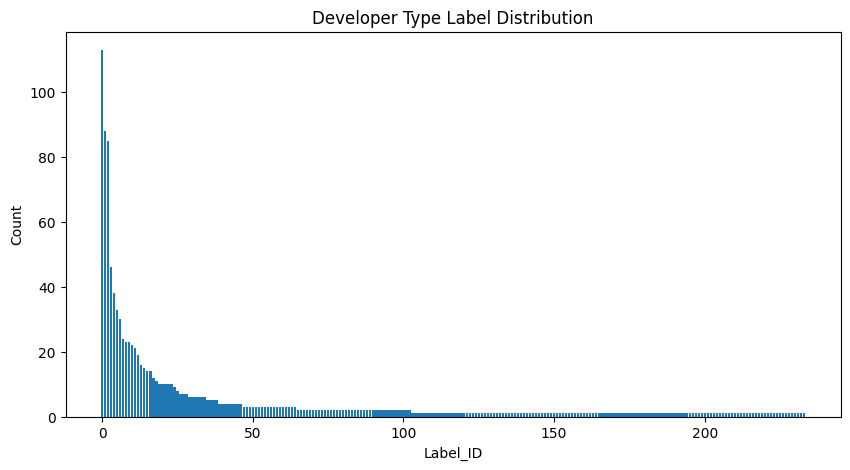

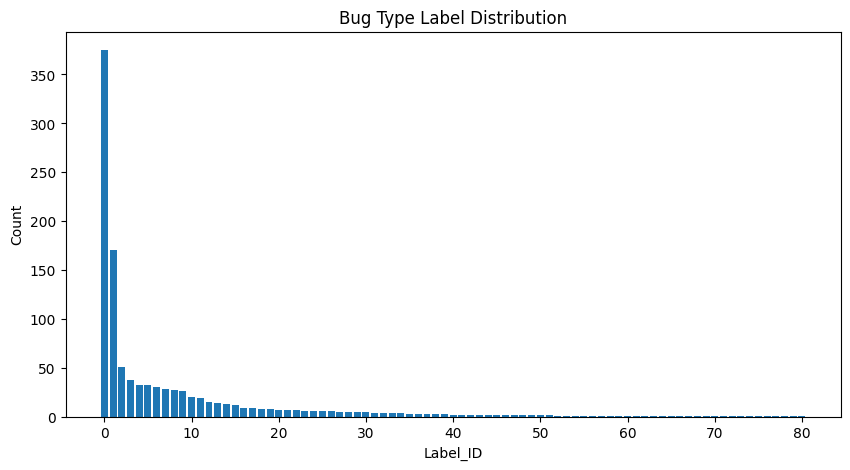

In [98]:
#TODO : data augmentation
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
def one_hot_to_indices(one_hot_array):
    indices = np.argmax(one_hot_array, axis=1)
    return indices

# 获取所有的标签
y_dev_labels = train_dataset.y_dev
y_btype_labels = train_dataset.y_btype

# print('y_dev_labels:', y_dev_labels[:1])
# print('y_btype_labels:', y_btype_labels[:1])
# print('len(y_dev_labels[0]):', len(y_dev_labels[0])) # number of developer types
# print('len(y_btype_labels[0]):', len(y_btype_labels[0])) #  number of bug types

# 使用你的独热编码数组调用函数
indices_dev = one_hot_to_indices(y_dev_labels.numpy())
# print(indices_dev)
indices_btype = one_hot_to_indices(y_btype_labels.numpy())
# print(indices_btype)

dev_idx2label = {i: idx2label[0][i] for i in range(len(idx2label[0]))}
btype_idx2label = {i: idx2label[1][i] for i in range(len(idx2label[1]))}

# 计算每个标签的出现次数
dev_label_counts = Counter(indices_dev)
btype_label_counts = Counter(indices_btype)

# 获取排序的键值对
dev_label_counts_sorted = dev_label_counts.most_common()
btype_label_counts_sorted = btype_label_counts.most_common()

# 打印出现次数排行
print('Developer Type Label Counts:')
for label, count in dev_label_counts_sorted:
    print(f'{dev_idx2label[label]}: {count}')

print('\nBug Type Label Counts:')
for label, count in btype_label_counts_sorted:
    print(f'{btype_idx2label[label]}: {count}')

# 画出直方图
plt.figure(figsize=(10, 5))
plt.bar(range(len(dev_label_counts)), [count for label, count in dev_label_counts_sorted])
plt.title('Developer Type Label Distribution')
plt.xlabel('Label_ID')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(range(len(btype_label_counts)), [count for label, count in btype_label_counts_sorted])
plt.title('Bug Type Label Distribution')
plt.xlabel('Label_ID')
plt.ylabel('Count')
plt.show()

# # 计算每个标签的出现次数
# dev_label_counts = np.sum(y_dev_labels.numpy(), axis=0)
# btype_label_counts = np.sum(y_btype_labels.numpy(), axis=0)

# # 获取排序的索引
# dev_sorted_indices = np.argsort(dev_label_counts)[::-1]
# btype_sorted_indices = np.argsort(btype_label_counts)[::-1]

# # 使用排序的索引来排序标签计数
# dev_label_counts_sorted = dev_label_counts[dev_sorted_indices]
# btype_label_counts_sorted = btype_label_counts[btype_sorted_indices]

# # 绘制y_dev标签的分布图
# plt.figure(figsize=(10, 5))
# plt.bar(range(len(dev_label_counts_sorted)), dev_label_counts_sorted)
# plt.title('y_dev Label Distribution')
# plt.xlabel('Label_ID')
# plt.ylabel('Count')
# plt.show()

# # 绘制y_btype标签的分布图
# plt.figure(figsize=(10, 5))
# plt.bar(range(len(btype_label_counts_sorted)), btype_label_counts_sorted)
# plt.title('y_btype Label Distribution')
# plt.xlabel('Label_ID')
# plt.ylabel('Count')
# plt.show()

In [99]:
print(len(idx2label[0]))
print(len(idx2label[1]))

386
181


In [100]:
print(len(train_loader))
for data in train_loader:
    (a, b), (c, d) = data
    print(a.shape)
    print(b.shape)
    print(c.shape)
    print(d.shape)
    (a, b), (c, d) = train_dataset[0]
    print(a.shape)
    print(b.shape)
    print(c.shape)
    print(d.shape)
    break

17
torch.Size([64, 300])
torch.Size([64, 300])
torch.Size([64, 386])
torch.Size([64, 181])
torch.Size([300])
torch.Size([300])
torch.Size([386])
torch.Size([181])


In [101]:
def testnan(name, x):
    if torch.isnan(x).any():
        print(name, x)

def repnan(x):
    return torch.where(torch.isnan(x), torch.ones_like(x), x)

In [102]:
#TODO :训练的太快了，是不是参数太少了拟合不了？
class MetaModel(nn.Module):
    def __init__(self, vocab_size: list, emb_dim: int, seq_len: int, num_out: list):
        """
        Args:
            vocab_size: list, the size of C/A vocab
            emb_dim: : int, the dim of C&A emb layer
            seq_len:  MAX_SEQ_LEN
            num_out: list, the output size of D/B
        """
        super(MetaModel, self).__init__()
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.seq_len = seq_len
        self.num_out = num_out

        self.context = nn.Sequential(
            nn.Embedding(self.vocab_size[0], self.emb_dim),
            nn.Conv1d(self.seq_len, 64, kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool1d(50, 1),
            nn.Flatten(),
        )
        self.AST = nn.Sequential(
            nn.Embedding(self.vocab_size[1], self.emb_dim),
            nn.Conv1d(self.seq_len, 50, kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(50, 100, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool1d(50, 1),
            nn.Flatten(),
        )
        self.fc = nn.Sequential(
            nn.BatchNorm1d(11172, affine=False),
            nn.Dropout(0.5),
            nn.Linear(11172, 5000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(5000, 1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, 500),
            nn.ReLU(),
        )
        self.fc_d = nn.Sequential(
            nn.Linear(500, self.num_out[0]),
            # nn.Softmax(dim=1),
            # nn.Sigmoid(),
        )

        self.fc_b = nn.Sequential(
            nn.Linear(500, self.num_out[1]),
            # nn.Softmax(dim=1),
            # nn.Sigmoid(),
        )

    def forward(self, x_C, x_A):
        # x, y
        x_C = self.context(x_C) 
        x_A = self.AST(x_A)
        x = torch.concat((x_C, x_A), 1)
        x = self.fc(x)
        y_d = self.fc_d(x) 
        y_b = self.fc_b(x) 
        return y_d, y_b 
# class MetaModel(nn.Module):
#     def __init__(self, vocab_size: list, emb_dim: int, seq_len: int, num_out: list):
#         """
#         Args:
#             vocab_size: list, the size of C/A vocab
#             emb_dim: : int, the dim of C&A emb layer
#             seq_len:  MAX_SEQ_LEN
#             num_out: list, the output size of D/B
#         """
#         super(MetaModel, self).__init__()
#         self.vocab_size = vocab_size
#         self.emb_dim = emb_dim
#         self.seq_len = seq_len
#         self.num_out = num_out

#         self.context = nn.Sequential(
#             nn.Embedding(self.vocab_size[0], self.emb_dim),
#             nn.Conv1d(self.seq_len, 64, kernel_size=2),
#             nn.ReLU(),
#             nn.MaxPool1d(99, 1),
#             nn.Flatten(),
#         )
#         self.AST = nn.Sequential(
#             nn.Embedding(self.vocab_size[1], self.emb_dim),
#             # nn.LSTM(self.emb_dim, 25, batch_first=True, bidirectional=True),
#             # nn.MaxPool1d(50, 1),
#             nn.Conv1d(self.seq_len, 50, kernel_size=2),
#             nn.ReLU(),
#             nn.MaxPool1d(99, 1),
#             nn.Flatten(),
#         )
#         self.fc = nn.Sequential(
#             nn.BatchNorm1d(114, affine=False), # one head
#             nn.Dropout(0.5),
#             nn.Linear(114, 50), # one head
#             nn.ReLU()
#         )
#         self.fc_d = nn.Sequential(
#             nn.Linear(50, self.num_out[0]),
#             nn.Sigmoid(),
#         )

#         self.fc_b = nn.Sequential(
#             nn.Linear(50, self.num_out[1]),
#             nn.Sigmoid(),
#         )

#     def forward(self, x_C, x_A):
#         # x, y
#         x_C = self.context(x_C) 
#         x_A = self.AST(x_A) # one head
#         x = torch.concat((x_C, x_A), 1) # one head
#         x = self.fc(x) # one head
#         y_d = self.fc_d(x) # one tail 
#         y_b = self.fc_b(x) # one tail 
#         return y_d, y_b # one tail

In [103]:
N_STEPS = len(train_loader) * EPOCH
def get_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=Learning_Rate,
        total_steps=N_STEPS,
        pct_start=0.10,
        anneal_strategy='cos',
        div_factor=1e3,
        final_div_factor=1e4,
    )


In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# model
model = MetaModel(vocab_size, EMB_DIM, MAX_SEQ_LEN, num_out).to(device)

# loss_func
# TODO: use loss functions for multi-label classification like focul loss or DBE
# def loss_fn(y, y_pred):
#     return -torch.sum(0.8*y*torch.log(y_pred) + 0.2*(1-y)*torch.log(1-y_pred))

# class ClassBalancedFocalLoss(nn.Module):
#     def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
#         super(ClassBalancedFocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction

#     def forward(self, target, input):
#         # Convert one-hot encoded target to class labels
#         target = torch.argmax(target, dim=1)
#         # 计算每个类别的权重
#         class_count = torch.bincount(target)
#         total_count = target.numel()
#         class_weights = 1.0 / (class_count.float() / total_count + 1e-6)

#         # 计算Focal Loss
#         ce_loss = F.cross_entropy(input, target, reduction='none')
#         pt = torch.exp(-ce_loss)
#         focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss

#         # 应用类别权重
#         class_weights = class_weights.to(input.device)
#         weight = class_weights[target]
#         balanced_focal_loss = weight * focal_loss

#         if self.reduction == 'mean':
#             return balanced_focal_loss.mean()
#         elif self.reduction == 'sum':
#             return balanced_focal_loss.sum()
#         else:
#             return balanced_focal_loss
        
# loss_fn = ClassBalancedFocalLoss(alpha=0.25, gamma=2.0, reduction='mean')
# loss_fn = torch.nn.BCEWithLogitsLoss().to(device)
# loss_fn_mse = torch.nn.MSELoss().to(device)
# loss_fn_ce = torch.nn.MultiLabelSoftMarginLoss().to(device)
# loss_fn_ce = torch.nn.BCEWithLogitsLoss().to(device)
loss_name = 'BCELogits_Adam'
# loss_func
def loss_fn(y, y_pred):
    return -torch.sum(0.8*y*torch.log(y_pred) + 0.2*(1-y)*torch.log(1-y_pred))

# loss_name = 'CBFocalLoss_Adam'

# Optimizer
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=Learning_Rate,
)

# Learning Rate Scheduler
LR_SCHEDULER = get_lr_scheduler(optimizer)

In [105]:
def metrics(y: torch.Tensor, pred: torch.Tensor, threshold_d, threshold_b, from_logits = True, split_pos = num_out):
    if from_logits == True:
        pred = nn.Sigmoid()(pred)
    # pred = torch.where(y_pred > threshold, 1, 0)
    y_d, y_b = torch.split(y, split_pos, dim=1)
    pred_d, pred_b = torch.split(pred, split_pos, dim=1)

    pred_d = torch.where(pred_d > threshold_d, 1, 0)
    pred_b = torch.where(pred_b > threshold_b, 1, 0)
    
    # print(y_d,pred_d)
    TPd, TPb = torch.sum(y_d * pred_d, dim=1), torch.sum(y_b * pred_b, dim=1)
    TNd, TNb = torch.sum((1-y_d) * (1-pred_d), dim=1), torch.sum((1-y_b) * (1-pred_b), dim=1)
    FPd, FPb = torch.sum((1-y_d) * pred_d , dim=1), torch.sum((1-y_b) * pred_b , dim=1)
    FNd, FNb = torch.sum(y_d * (1-pred_d), dim=1), torch.sum(y_b * (1-pred_b), dim=1)

    acc = torch.mean((TPd + TNd) / (TPd + TNd + FPd + FNd + 1e-6)).item(), torch.mean((TPb + TNb) / (TPb + TNb + FPb + FNb + 1e-6)).item()
    recall = torch.mean(TPd / (TPd + FNd + 1e-6)).item(), torch.mean(TPb / (TPb + FNb + 1e-6)).item()
    precision = torch.mean(TPd / (TPd + FPd + 1e-6)).item(), torch.mean(TPb / (TPb + FPb + 1e-6)).item()
    F1 = 2 * recall[0] * precision[0] / (recall[0] + precision[0] + 1e-6), 2 * recall[1] * precision[1] / (recall[1] + precision[1] + 1e-6)
    
    return {
        'acc': acc,
        'precision': precision,
        'recall': recall,
        'F1': F1
    }

def one_forward(data):
    (x_context, x_AST), (y_dev, y_btype) = data
    y_dev_pred, y_btype_pred = model(x_context.long().to(device), x_AST.long().to(device)) 
    
    y = torch.concat((y_dev, y_btype), 1).to(device) 
    y_pred = torch.concat((y_dev_pred, y_btype_pred), 1) 

    # loss = Weight_MSE * loss_fn_mse(y, nn.Sigmoid()(y_pred)) + Weight_BCE * loss_fn_ce(y, y_pred)
    loss = loss_fn(y, y_pred)
    metric = metrics(y, y_pred, from_logits=False, split_pos=num_out, threshold_d=0.62,threshold_b=0.58)
    
    return loss, metric['acc'], metric['precision'], metric['recall'], metric['F1']


def one_backward(optimizer, loss):
    optimizer.zero_grad()
    loss.backward()
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

def one_train_scaler(scaler, data, optimizer):
    with torch.cuda.amp.autocast():
        optimizer.zero_grad()
        loss, acc, precision, recall, f1 = one_forward(data)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

In [106]:
print(num_out)

[386, 181]


In [107]:
from torch.utils.tensorboard import SummaryWriter
# torch.autograd.set_detect_anomaly(True)
# scaler = torch.cuda.amp.GradScaler()

writer = SummaryWriter('./tf-logs')
for epoch in tqdm.trange(EPOCH):

    # train
    model.train()
    for step, data in enumerate(train_loader):

        loss, acc, precision, recall, f1 = one_forward(data)
        one_backward(optimizer, loss)
        
        # one_train_scaler(scaler, data, optimizer)
        # LR_SCHEDULER.step()
        

    # val
    model.eval()
    val_loss, val_acc, val_precision, val_recall, val_F1 = 0, [0, 0], [0, 0], [0, 0], [0, 0]
    with torch.no_grad():
        for step, data in enumerate(test_loader):
            loss, acc, precision, recall, f1 = one_forward(data)
            l = len(test_loader)
            val_loss += loss.item() / l
            val_acc[0] += acc[0]/l
            val_acc[1] += acc[1]/l
            val_precision[0] += precision[0]/l
            val_precision[1] += precision[1]/l
            val_recall[0] += recall[0]/l
            val_recall[1] += recall[1]/l
            val_F1[0] += f1[0]/l 
            val_F1[1] += f1[1]/l 
            
    # print('{}th epoch\n val_loss: {}\n val_acc:{}\n val_precision:{}\n val_recall:{}\n val_f1: {}'.format(epoch, val_loss, val_acc, val_precision, val_recall, val_F1))
    writer.add_scalar('val_loss'+loss_name+str(Learning_Rate), val_loss, epoch)
    writer.add_scalar('val_acc_d'+loss_name+str(Learning_Rate), val_acc[0], epoch)
    writer.add_scalar('val_acc_b'+loss_name+str(Learning_Rate), val_acc[1], epoch)
    # writer.add_scalar('val_precision'+loss_name+str(Learning_Rate), val_precision, epoch)
    # writer.add_scalar('val_recall'+loss_name+str(Learning_Rate), val_recall, epoch)
    writer.add_scalar('val_f1_d'+loss_name+str(Learning_Rate), val_F1[0], epoch)
    writer.add_scalar('val_f1_b'+loss_name+str(Learning_Rate), val_F1[1], epoch)

    # save model
    # if epoch % 20 == 0:
        # torch.save(model, '../savedmodel/model_epoch{}.pth'.format(epoch))

writer.close()

  0%|          | 0/300 [00:00<?, ?it/s]


UnboundLocalError: local variable 'pred' referenced before assignment

In [ ]:
(x_c, x_a), (y_d, y_b) = test_dataset[0]
x_c = torch.reshape(x_c.long().to(device), (1, 300))
x_a = torch.reshape(x_a.long().to(device), (1, 300))
y_d_pred, y_b_pred = model(x_c, x_a)

y_d_pred, y_b_pred = nn.Sigmoid()(y_d_pred), nn.Sigmoid()(y_b_pred)
print(y_d_pred, y_b_pred)
# print(y_d_pred[0][-29])
#TODO: 调整阈值
#TODO: 多标签分类问题：换用F1分数、Hamming损失或Jaccard相似度
print(torch.where(y_d_pred > 0.62, 1.0, 0.0), torch.where(y_b_pred > 0.58, 1.0, 0.0))


tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

In [ ]:
print(y_d,y_b)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
print(num_out)

[386, 181]
